# SNPsnap Enrichment

**Created**: 13 June 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(GenomicRanges)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The followi

## Load Data

Load the overlaps between matched SNPs for cis-eQTL and conditional cis-eQTL and various annotations.

In [2]:
cis.overlaps <- fread("~/gains_team282/epigenetics/enrichment/snp_snap/cis_eqtl_matched_snp_overlaps.tsv") %>%
    as.data.frame() %>%
    dplyr::mutate(Proportion_Overlap = Overlap / N_SNPS) %>%
    dplyr::select(Set, Annotation, Proportion_Overlap) %>%
    tidyr::spread(Annotation, Proportion_Overlap) %>%
    dplyr::select(-Set)

In [3]:
c.cis.overlaps <- fread("~/gains_team282/epigenetics/enrichment/snp_snap/conditional_cis_eqtl_matched_snp_overlaps.tsv") %>%
    as.data.frame() %>%
    dplyr::mutate(Proportion_Overlap = Overlap / N_SNPS) %>%
    dplyr::select(Set, Annotation, Proportion_Overlap) %>%
    tidyr::spread(Annotation, Proportion_Overlap) %>%
    dplyr::select(-Set)

In [4]:
sepsis.overlaps <- fread("~/gains_team282/epigenetics/enrichment/snp_snap/sepsis_enhanced_matched_snp_overlaps.tsv") %>%
    as.data.frame() %>%
    dplyr::mutate(Proportion_Overlap = Overlap / N_SNPS) %>%
    dplyr::select(Set, Annotation, Proportion_Overlap) %>%
    tidyr::spread(Annotation, Proportion_Overlap) %>%
    dplyr::select(-Set)

Load observed overlaps.

In [5]:
cis.observed <- fread("~/gains_team282/epigenetics/enrichment/snp_snap/cis_eqtl_observed_snp_overlaps.tsv") %>%
    as.data.frame() %>%
    dplyr::mutate(Proportion_Overlap = Overlap / N_SNPS) %>%
    dplyr::select(Set, Annotation, Proportion_Overlap) %>%
    tidyr::spread(Annotation, Proportion_Overlap) %>%
    dplyr::select(-Set)

In [6]:
c.cis.observed <- fread("~/gains_team282/epigenetics/enrichment/snp_snap/conditional_cis_eqtl_observed_snp_overlaps.tsv") %>%
    as.data.frame() %>%
    dplyr::mutate(Proportion_Overlap = Overlap / N_SNPS) %>%
    dplyr::select(Set, Annotation, Proportion_Overlap) %>%
    tidyr::spread(Annotation, Proportion_Overlap) %>%
    dplyr::select(-Set)

In [7]:
sepsis.observed <- fread("~/gains_team282/epigenetics/enrichment/snp_snap/sepsis_enhanced_observed_snp_overlaps.tsv") %>%
    as.data.frame() %>%
    dplyr::mutate(Proportion_Overlap = Overlap / N_SNPS) %>%
    dplyr::select(Set, Annotation, Proportion_Overlap) %>%
    tidyr::spread(Annotation, Proportion_Overlap) %>%
    dplyr::select(-Set)

## Immune Atlas

In [8]:
lineages <- read.csv("03_Functional_Interpretation/data/Calderon_et_al_lineages.csv")

In [9]:
head(lineages)

,Lineage,Cell_Type
,<chr>,<chr>
1,B,Bulk_B
2,B,Mem_B
3,B,Naive_B
4,B,Plasmablasts
5,CD8,CD8pos_T
6,CD8,Central_memory_CD8pos_T


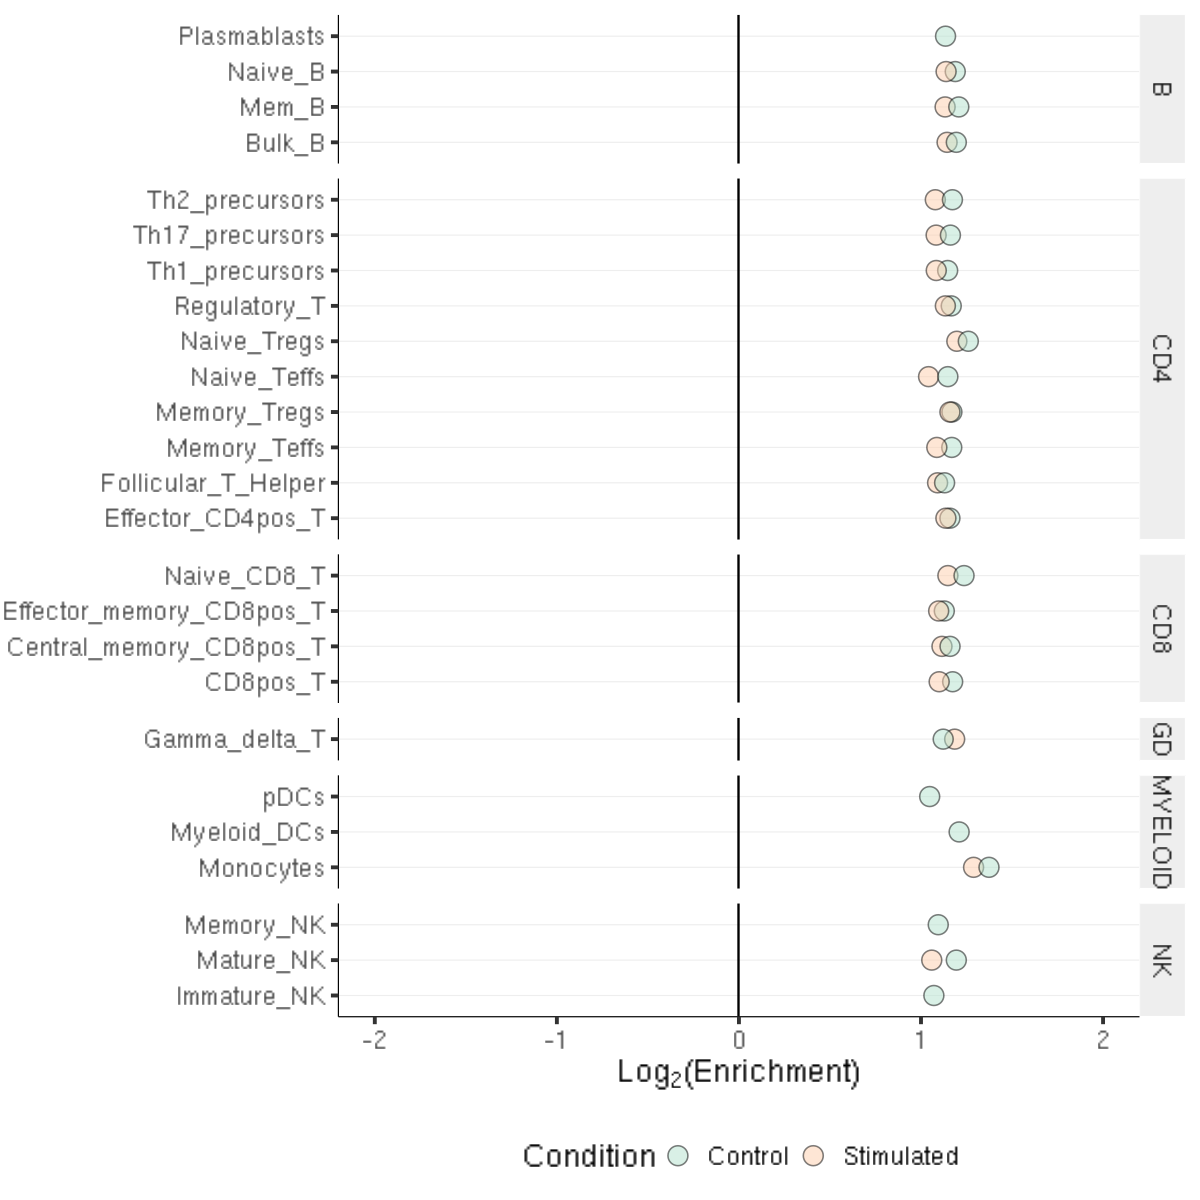

In [10]:
options(repr.plot.width=10, repr.plot.height=10)

dplyr::bind_rows(
    cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("Control|Stimulated", Peaks)) %>%
    dplyr::mutate(Condition=gsub(".*-", "", Peaks)) %>%
    dplyr::mutate(Peaks=gsub("-.*", "", Peaks)) %>%
    merge(., lineages, by.x="Peaks", by.y="Cell_Type") %>%
    ggplot() +
    geom_point(aes(x=Peaks, y=Log.Enrichment, fill=Condition), shape=21, size=I(5), alpha=0.5) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    facet_grid(Lineage ~ ., scale="free_y", space="free_y") +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_immune_atlas.svg", width=10, height=10)

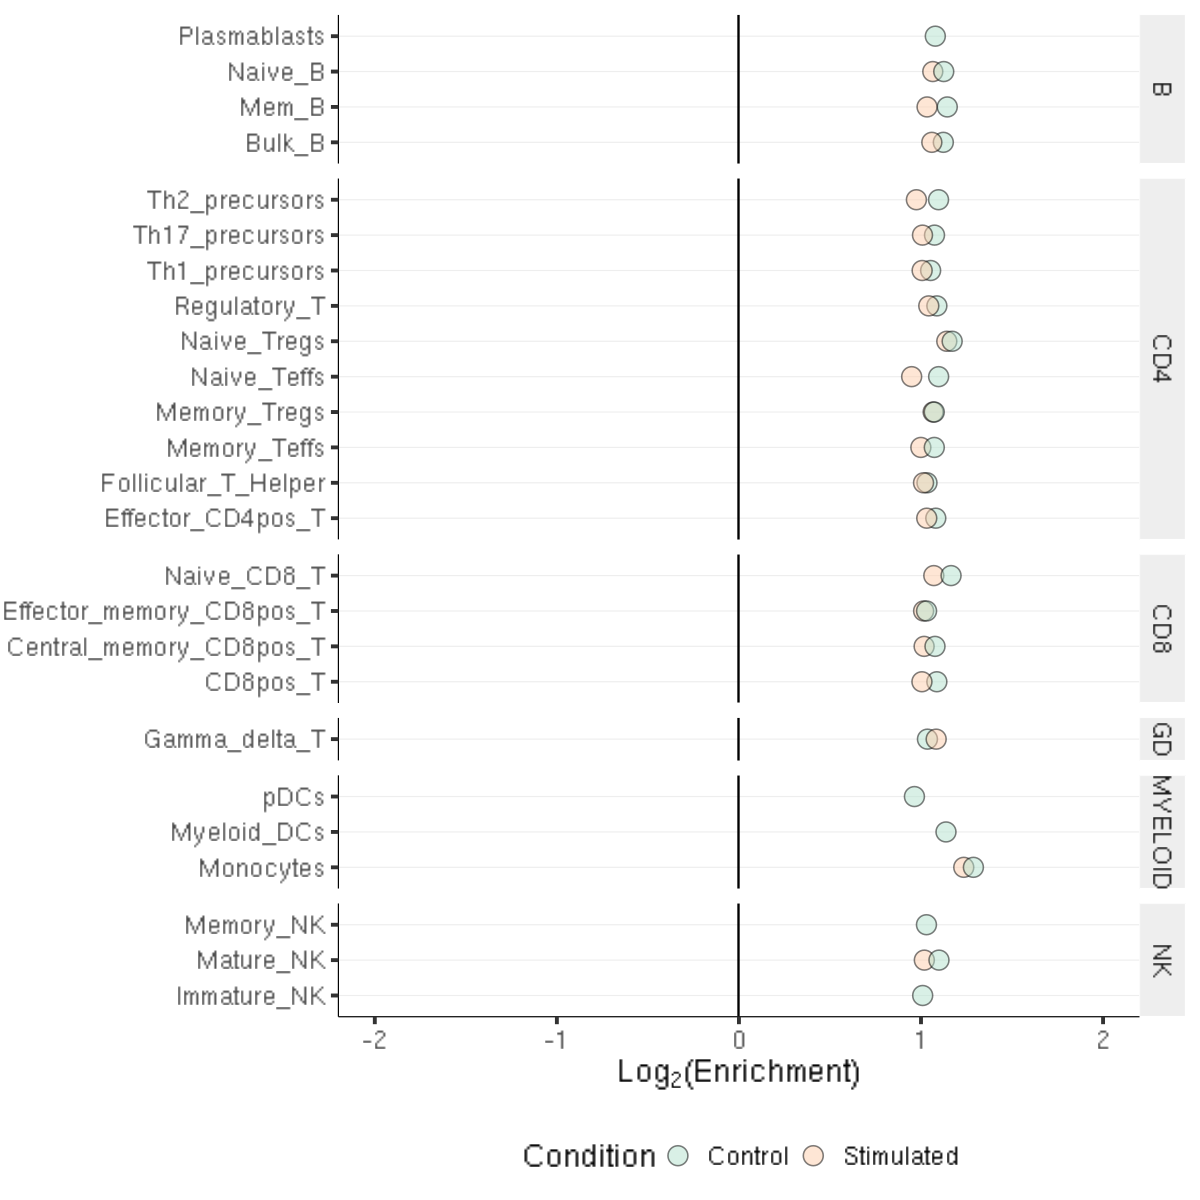

In [11]:
options(repr.plot.width=10, repr.plot.height=10)

dplyr::bind_rows(
    c.cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    c.cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("Control|Stimulated", Peaks)) %>%
    dplyr::mutate(Condition=gsub(".*-", "", Peaks)) %>%
    dplyr::mutate(Peaks=gsub("-.*", "", Peaks)) %>%
    merge(., lineages, by.x="Peaks", by.y="Cell_Type") %>%
    ggplot() +
    geom_point(aes(x=Peaks, y=Log.Enrichment, fill=Condition), shape=21, size=I(5), alpha=0.5) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    facet_grid(Lineage ~ ., scale="free_y", space="free_y") +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_immune_atlas_conditional.svg", width=10, height=10)

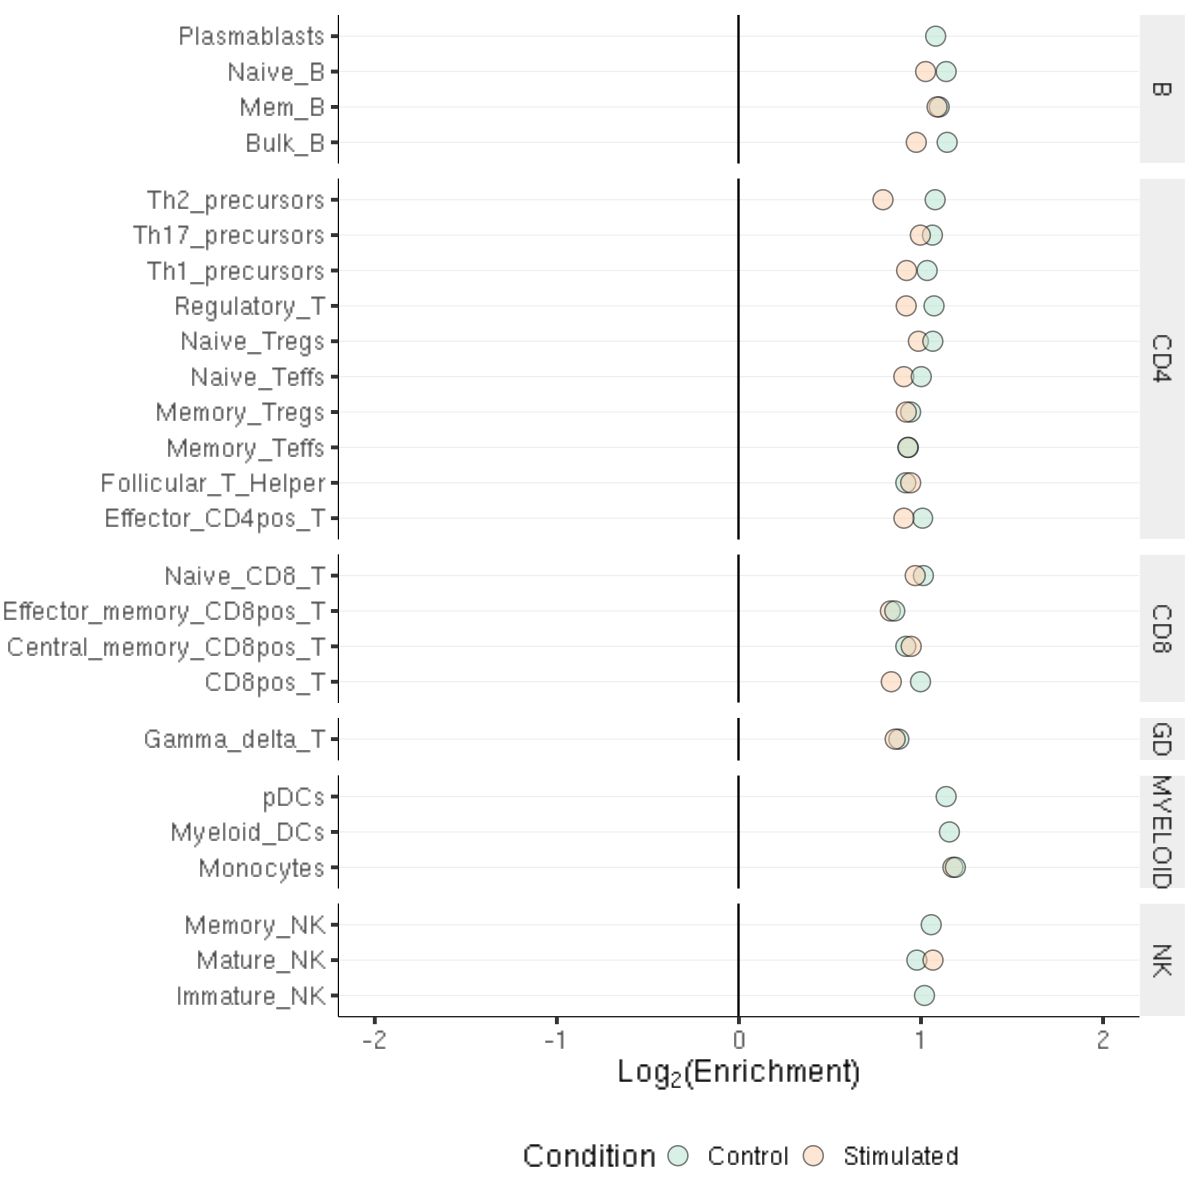

In [12]:
options(repr.plot.width=10, repr.plot.height=10)

dplyr::bind_rows(
    sepsis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    sepsis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("Control|Stimulated", Peaks)) %>%
    dplyr::mutate(Condition=gsub(".*-", "", Peaks)) %>%
    dplyr::mutate(Peaks=gsub("-.*", "", Peaks)) %>%
    merge(., lineages, by.x="Peaks", by.y="Cell_Type") %>%
    ggplot() +
    geom_point(aes(x=Peaks, y=Log.Enrichment, fill=Condition), shape=21, size=I(5), alpha=0.5) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    facet_grid(Lineage ~ ., scale="free_y", space="free_y") +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

## Neutrophil Atlas

In [13]:
conditions <- data.frame(
    Condition=c("Control", "LTA", "LPS", "FLAG", "R848", "BGP", "HMGB1", "WB", "SA-1", "SA-3", "SA-5", "noEC1h", "EC1h", "noEC4h", "EC4h"),
    Experiment=c(rep("Ligand", 7), rep("S. aureus", 4), rep("E. coli", 4))
) %>%
    dplyr::mutate(Condition=factor(Condition, levels=Condition)) %>%
    dplyr::mutate(Experiment=factor(Experiment, levels=c("Ligand", "S. aureus", "E. coli")))

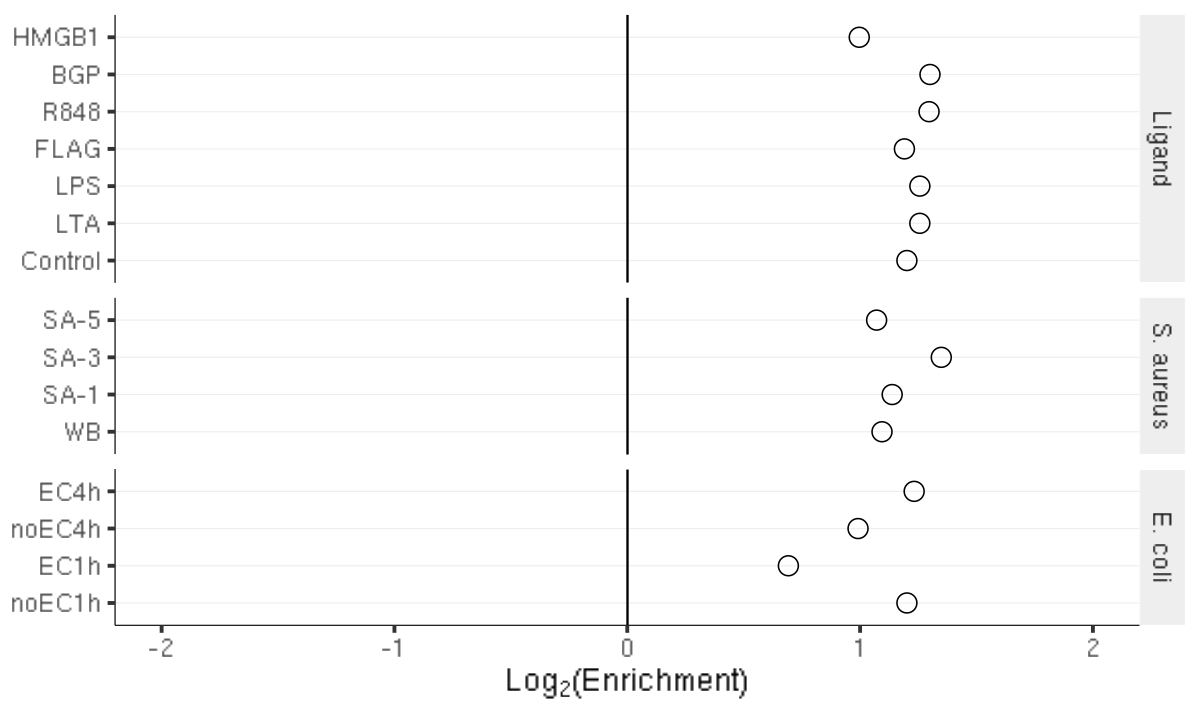

In [14]:
options(repr.plot.width=10, repr.plot.height=6)

dplyr::bind_rows(
    cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("Neutrophils", Peaks)) %>%
    dplyr::mutate(Condition=gsub("Neutrophils-", "", Peaks)) %>%
    merge(conditions, ., by="Condition") %>%
    ggplot() +
    geom_point(aes(x=Condition, y=Log.Enrichment), shape=21, size=I(5)) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    facet_grid(Experiment ~ ., scale="free_y", space="free_y") +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_neutrophil_atlas.svg", width=10, height=6)

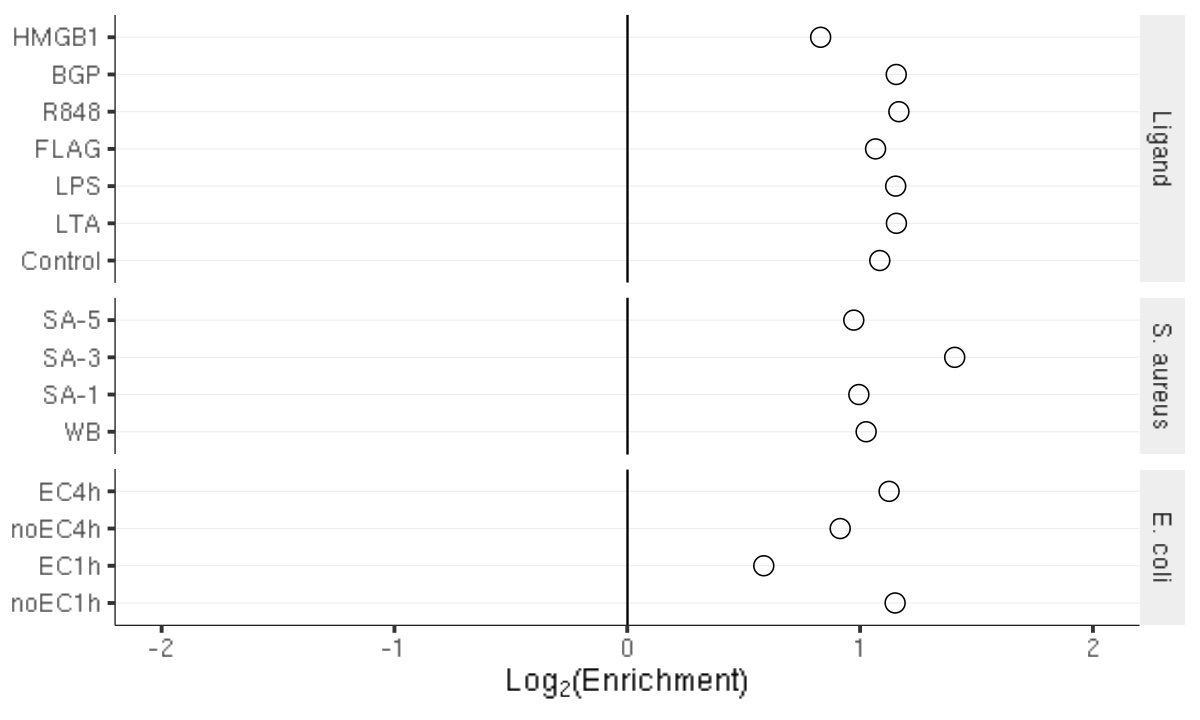

In [15]:
options(repr.plot.width=10, repr.plot.height=6)

dplyr::bind_rows(
    c.cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    c.cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("Neutrophils", Peaks)) %>%
    dplyr::mutate(Condition=gsub("Neutrophils-", "", Peaks)) %>%
    merge(conditions, ., by="Condition") %>%
    ggplot() +
    geom_point(aes(x=Condition, y=Log.Enrichment), shape=21, size=I(5)) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    facet_grid(Experiment ~ ., scale="free_y", space="free_y") +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_neutrophil_atlas_conditional.svg", width=10, height=6)

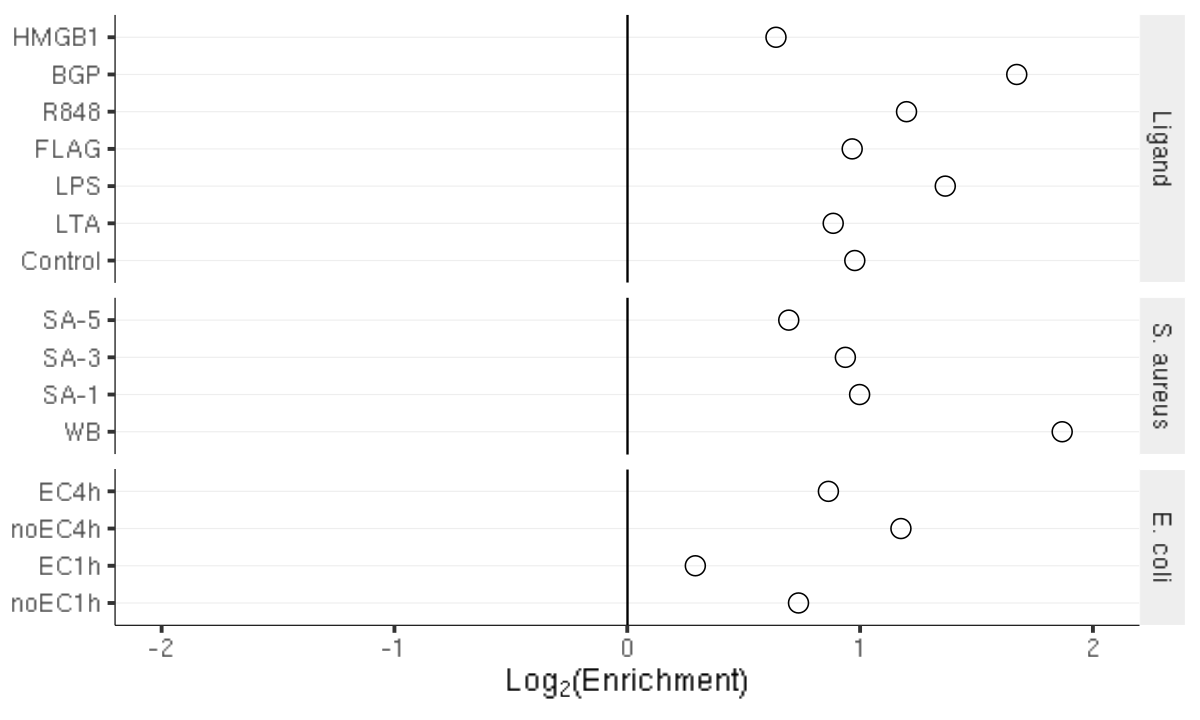

In [16]:
options(repr.plot.width=10, repr.plot.height=6)

dplyr::bind_rows(
    sepsis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    sepsis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("Neutrophils", Peaks)) %>%
    dplyr::mutate(Condition=gsub("Neutrophils-", "", Peaks)) %>%
    merge(conditions, ., by="Condition") %>%
    ggplot() +
    geom_point(aes(x=Condition, y=Log.Enrichment), shape=21, size=I(5)) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    facet_grid(Experiment ~ ., scale="free_y", space="free_y") +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

## Encode cCREs

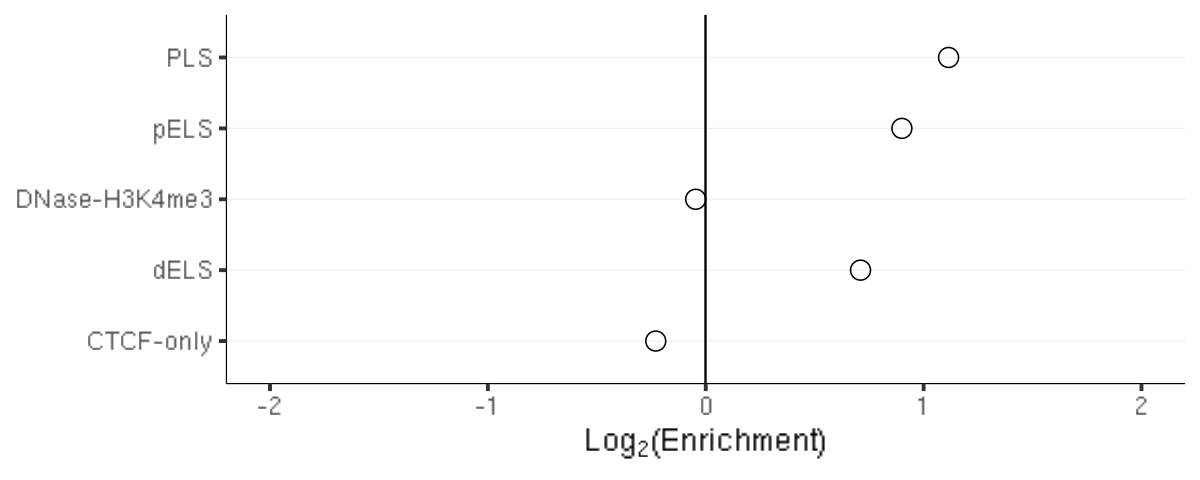

In [17]:
options(repr.plot.width=10, repr.plot.height=4)

dplyr::bind_rows(
    cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("GRCh38", Peaks)) %>%
    dplyr::mutate(Condition=gsub("GRCh38-cCREs\\.", "", Peaks)) %>%
    ggplot() +
    geom_point(aes(x=Condition, y=Log.Enrichment), shape=21, size=I(5)) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_encode_ccres.svg", width=10, height=4)

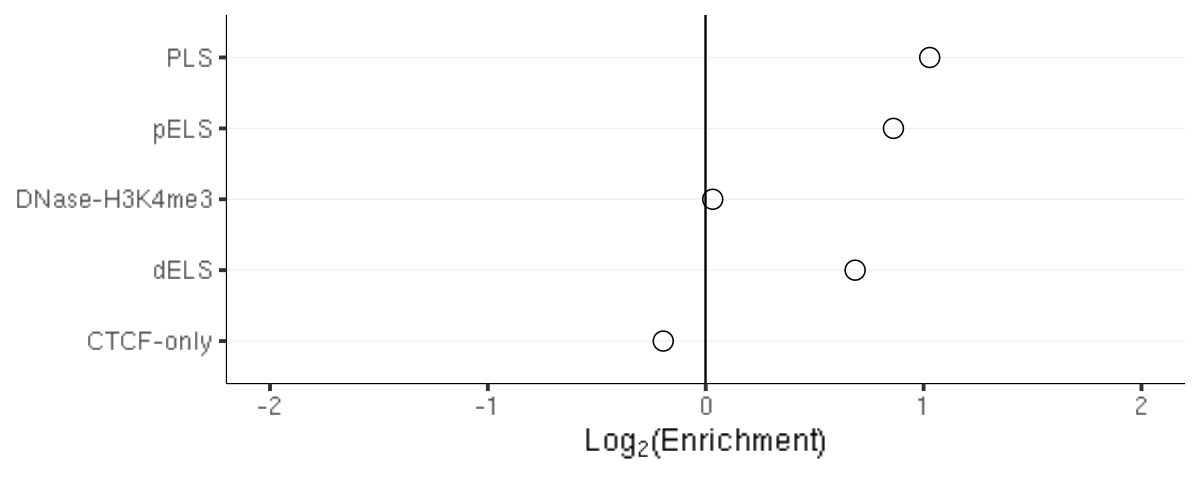

In [18]:
options(repr.plot.width=10, repr.plot.height=4)

dplyr::bind_rows(
    c.cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    c.cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("GRCh38", Peaks)) %>%
    dplyr::mutate(Condition=gsub("GRCh38-cCREs\\.", "", Peaks)) %>%
    ggplot() +
    geom_point(aes(x=Condition, y=Log.Enrichment), shape=21, size=I(5)) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_encode_ccres_conditional.svg", width=10, height=4)

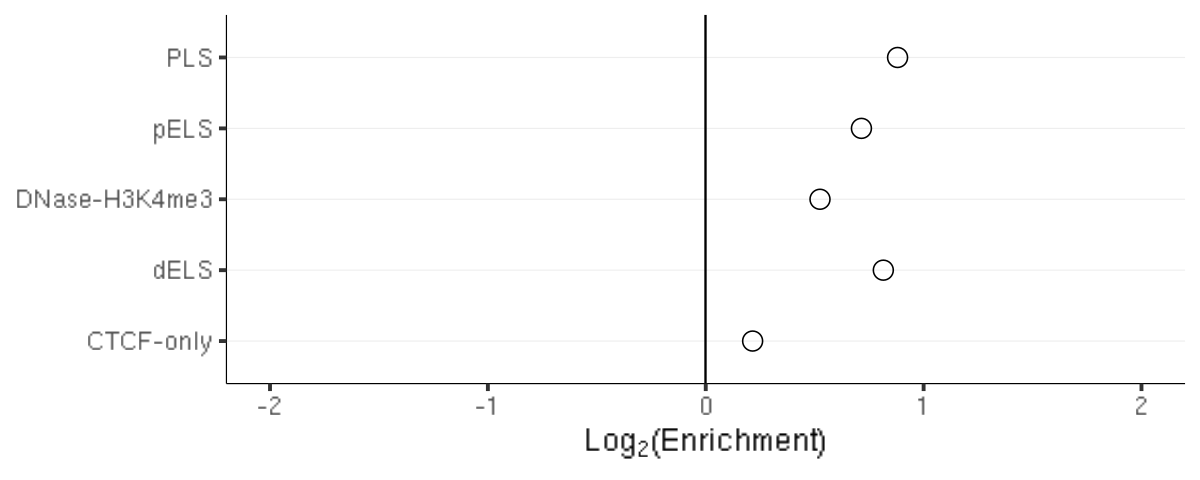

In [19]:
options(repr.plot.width=10, repr.plot.height=4)

dplyr::bind_rows(
    sepsis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    sepsis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("GRCh38", Peaks)) %>%
    dplyr::mutate(Condition=gsub("GRCh38-cCREs\\.", "", Peaks)) %>%
    ggplot() +
    geom_point(aes(x=Condition, y=Log.Enrichment), shape=21, size=I(5)) +
    geom_hline(aes(yintercept=0)) +
    scale_fill_brewer(palette="Pastel2") +
    ylim(-2, 2) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    coord_flip() +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

## ROADMAP ChromHMM

In [20]:
hmm.meta <- read.csv("03_Functional_Interpretation/metadata/roadmap_epigenomics_chromhmm.csv")

In [21]:
head(hmm.meta[,1:4])

,Epigenome_ID,Group,Epigenome_Name,Short_Name
,<chr>,<chr>,<chr>,<chr>
1,E029,HSC & B-cell,Primary monocytes from peripheral blood,Monocytes
2,E032,HSC & B-cell,Primary B cells from peripheral blood,B cells
3,E034,Blood & T-cell,Primary T cells from peripheral blood,T cells
4,E038,Blood & T-cell,Primary T helper naive cells from peripheral blood,Naive T helper cells
5,E043,Blood & T-cell,Primary T helper cells from peripheral blood,T helper cells
6,E044,Blood & T-cell,Primary T regulatory cells from peripheral blood,Regulatory T cells


In [22]:
states <- read.csv("03_Functional_Interpretation/data/roadmap_epigenomics_chromhmm_states.csv") %>%
    dplyr::mutate(State=paste0("E", State)) %>%
    dplyr::mutate(Description=factor(Description, levels=Description))

In [23]:
head(states)

,State,Mnemonic,Description
,<chr>,<chr>,<fct>
1,E1,TssA,Active TSS
2,E2,TssFlnk,Flanking TSS
3,E3,TssFlnkU,Flanking TSS Upstream
4,E4,TssFlnkD,Flanking TSS Downstream
5,E5,Tx,Strong transcription
6,E6,TxWk,Weak transcription


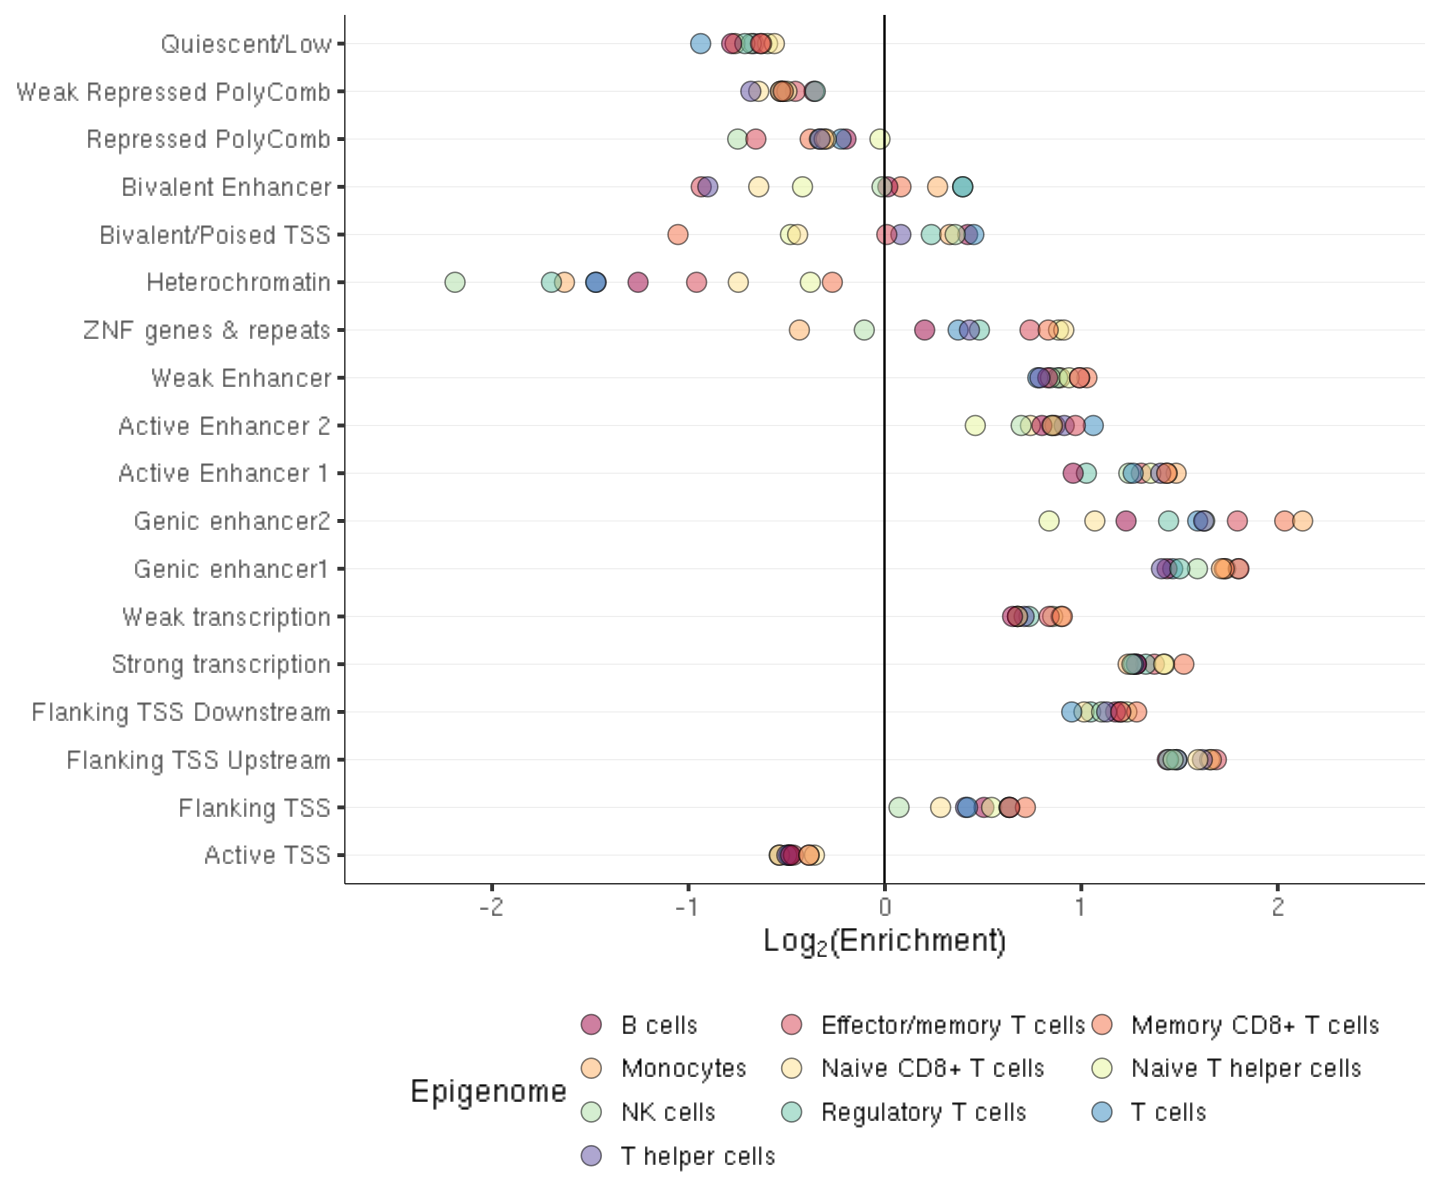

In [24]:
options(repr.plot.width=12, repr.plot.height=10)

dplyr::bind_rows(
    cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("-E[0-9]+$", Peaks)) %>%
    dplyr::mutate(State=factor(gsub(".*-", "", Peaks), levels=paste0("E", 1:18))) %>%
    dplyr::mutate(Sample=gsub("_.*", "", Peaks)) %>%
    merge(., hmm.meta, by.x="Sample", by.y="Epigenome_ID") %>%
    merge(., states, by="State") %>%
    ggplot() +
    geom_point(aes(x=Description, y=Log.Enrichment, fill=Short_Name), shape=21, size=I(5), alpha=0.5) +
    geom_hline(aes(yintercept=0)) +
    ylim(-2.5, 2.5) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    scale_fill_brewer(palette="Spectral") +
    guides(fill = guide_legend("Epigenome", nrow = 4, byrow = TRUE)) +
    coord_flip() +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_chromhmm.svg", width=12, height=10)

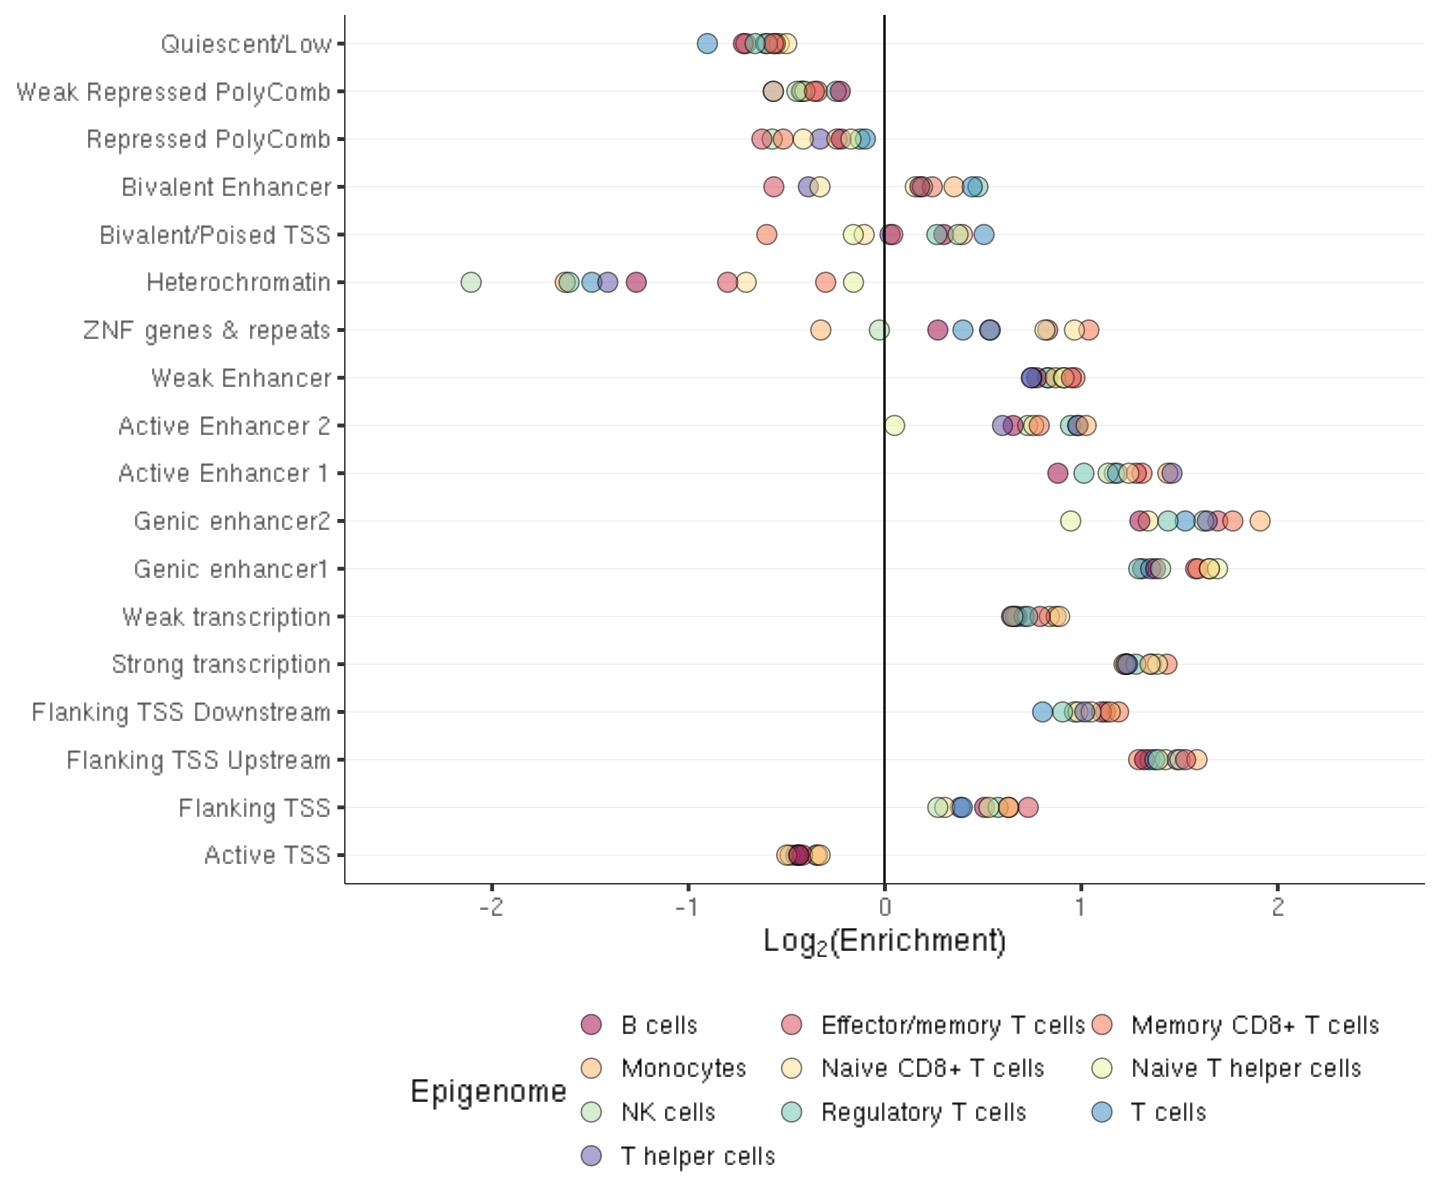

In [25]:
options(repr.plot.width=12, repr.plot.height=10)

dplyr::bind_rows(
    c.cis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    c.cis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("-E[0-9]+$", Peaks)) %>%
    dplyr::mutate(State=factor(gsub(".*-", "", Peaks), levels=paste0("E", 1:18))) %>%
    dplyr::mutate(Sample=gsub("_.*", "", Peaks)) %>%
    merge(., hmm.meta, by.x="Sample", by.y="Epigenome_ID") %>%
    merge(., states, by="State") %>%
    ggplot() +
    geom_point(aes(x=Description, y=Log.Enrichment, fill=Short_Name), shape=21, size=I(5), alpha=0.5) +
    geom_hline(aes(yintercept=0)) +
    ylim(-2.5, 2.5) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    scale_fill_brewer(palette="Spectral") +
    guides(fill = guide_legend("Epigenome", nrow = 4, byrow = TRUE)) +
    coord_flip() +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/snp_snap_enrichment_chromhmm_conditional.svg", width=12, height=10)

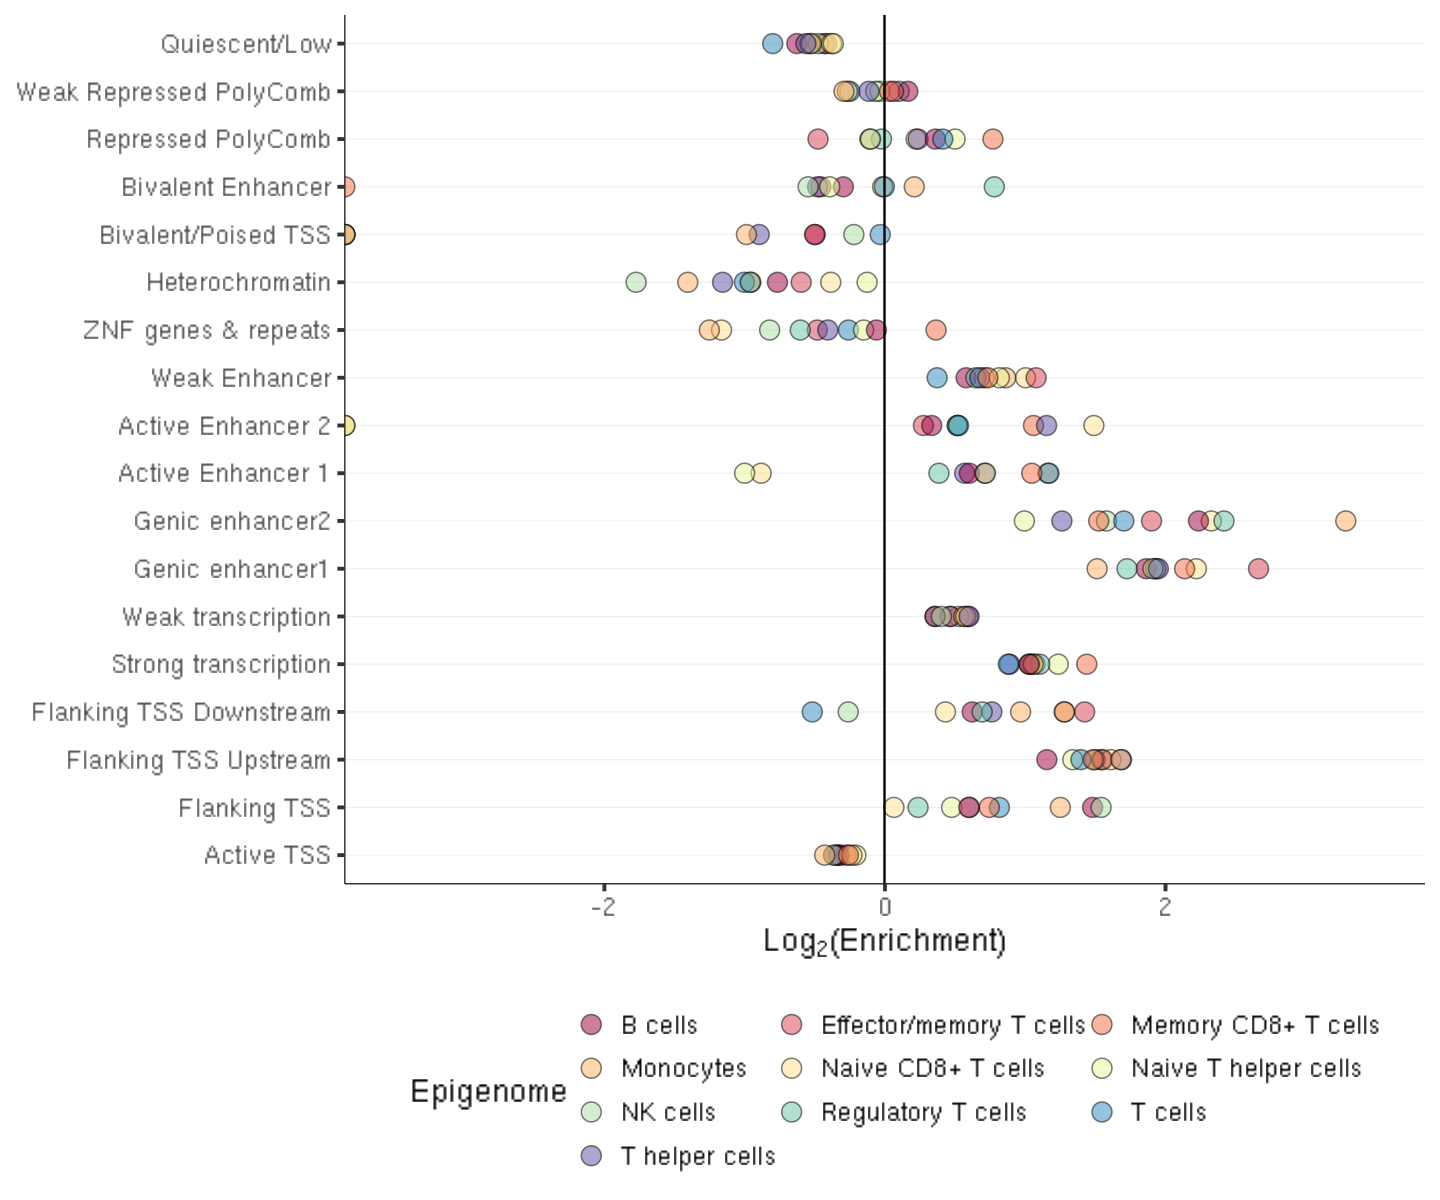

In [28]:
options(repr.plot.width=12, repr.plot.height=10)

dplyr::bind_rows(
    sepsis.overlaps %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Matched"),
    sepsis.observed %>%
        tidyr::gather("Peaks", "Overlap") %>%
        dplyr::mutate(Type="Observed")
) %>%
    dplyr::group_by(Peaks, Type) %>%
    dplyr::summarize(Mean.Overlap=mean(Overlap), .groups="drop") %>%
    tidyr::spread(Type, Mean.Overlap) %>%
    dplyr::mutate(Log.Enrichment=log2(Observed / Matched)) %>%
    dplyr::arrange(Log.Enrichment) %>%
    dplyr::mutate(Peaks=factor(Peaks, levels=Peaks)) %>%
    dplyr::filter(grepl("-E[0-9]+$", Peaks)) %>%
    dplyr::mutate(State=factor(gsub(".*-", "", Peaks), levels=paste0("E", 1:18))) %>%
    dplyr::mutate(Sample=gsub("_.*", "", Peaks)) %>%
    merge(., hmm.meta, by.x="Sample", by.y="Epigenome_ID") %>%
    merge(., states, by="State") %>%
    ggplot() +
    geom_point(aes(x=Description, y=Log.Enrichment, fill=Short_Name), shape=21, size=I(5), alpha=0.5) +
    geom_hline(aes(yintercept=0)) +
    ylim(-3.5, 3.5) + ylab(bquote("Log"[2]*"(Enrichment)")) +
    scale_fill_brewer(palette="Spectral") +
    guides(fill = guide_legend("Epigenome", nrow = 4, byrow = TRUE)) +
    coord_flip() +
    ggplot_theme +
    theme(panel.grid.major.y=element_line(size=0.25, color="#EEEEEE"), axis.title.y=element_blank())